# Logistic Regression

In this part of the exercise, you will build a logistic regression model to predict whether a student gets admitted into a university.

### Problem Statement

Suppose that you are the administrator of a university department and you want to determine each applicant’s chance of admission based on their results on two exams. 
* You have historical data from previous applicants that you can use as a training set for logistic regression. 
* For each training example, you have the applicant’s scores on two exams and the admissions decision. 
* Your task is to build a classification model that estimates an applicant’s probability of admission based on the scores from those two exams. 

## Import dependencies

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import copy
import math
%matplotlib inline

In [2]:
df = pd.read_csv('../datasets/ex2data1.txt', sep=',', header=None)
df.columns = ['exam_score_1', 'exam_score_2', 'label']
df.head()

,exam_score_1,exam_score_2,label
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


In [3]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
exam_score_1,100.0,65.644274,19.458222,30.058822,50.919511,67.032988,80.212529,99.827858
exam_score_2,100.0,66.221998,18.582783,30.603263,48.179205,67.682381,79.360605,98.869436
label,100.0,0.600000,0.492366,0.000000,0.000000,1.000000,1.000000,1.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   exam_score_1  100 non-null    float64
 1   exam_score_2  100 non-null    float64
 2   label         100 non-null    int64  
dtypes: float64(2), int64(1)
memory usage: 2.5 KB


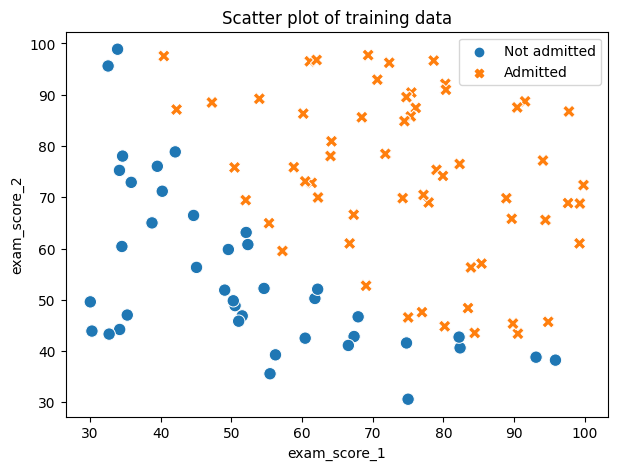

In [5]:
plt.figure(figsize=(7,5))
ax = sns.scatterplot(x='exam_score_1', y='exam_score_2', hue='label', data=df, style='label', s=80)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[0:], ['Not admitted', 'Admitted'])
plt.title('Scatter plot of training data')
plt.show(ax)

In [6]:
X_train,y_train = df.drop(['label'],axis=1) , df['label']
print(X_train.shape)
print(y_train.shape)

(100, 2)
(100,)


<a name="2.3"></a>
### 2.3  Sigmoid function

Recall that for logistic regression, the model is represented as

$$ f_{\mathbf{w},b}(x) = g(\mathbf{w}\cdot \mathbf{x} + b)$$
where function $g$ is the sigmoid function. The sigmoid function is defined as:

$$g(z) = \frac{1}{1+e^{-z}}$$


In [7]:
def sigmoid(z):
    """
    Compute the sigmoid of z
    
    Args:
        z (ndarray): A scalar, numpy array of any size.
    Returns:
        g (ndarray): sigmoid(z), with the same shape as z
         
    """          
    g = 1/(1+np.exp(-z))
    return g

In [8]:
# Note: You can edit this value
value = 0

print (f"sigmoid({value}) = {sigmoid(value)}")

sigmoid(0) = 0.5


<a name="2.4"></a>
### Cost function for logistic regression

<a name='ex-02'></a>



$$ J(\mathbf{w},b) = \frac{1}{m}\sum_{i=0}^{m-1} \left[ loss(f_{\mathbf{w},b}(\mathbf{x}^{(i)}), y^{(i)}) \right] \tag{1}$$

where
* m is the number of training examples in the dataset


* $loss(f_{\mathbf{w},b}(\mathbf{x}^{(i)}), y^{(i)})$ is the cost for a single data point, which is - 

    $$loss(f_{\mathbf{w},b}(\mathbf{x}^{(i)}), y^{(i)}) = (-y^{(i)} \log\left(f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right) - \left( 1 - y^{(i)}\right) \log \left( 1 - f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right) \tag{2}$$
    
    
*  $f_{\mathbf{w},b}(\mathbf{x}^{(i)})$ is the model's prediction, while $y^{(i)}$, which is the actual label

*  $f_{\mathbf{w},b}(\mathbf{x}^{(i)}) = g(\mathbf{w} \cdot \mathbf{x^{(i)}} + b)$ where function $g$ is the sigmoid function.
    * It might be helpful to first calculate an intermediate variable $z_{\mathbf{w},b}(\mathbf{x}^{(i)}) = \mathbf{w} \cdot \mathbf{x^{(i)}} + b = w_0x^{(i)}_0 + ... + w_{n-1}x^{(i)}_{n-1} + b$ where $n$ is the number of features, before calculating $f_{\mathbf{w},b}(\mathbf{x}^{(i)}) = g(z_{\mathbf{w},b}(\mathbf{x}^{(i)}))$



In [9]:
def compute_cost(X, y, w, b, *argv):
    """
    Computes the cost over all examples
    Args:
      X : (ndarray Shape (m,n)) data, m examples by n features
      y : (ndarray Shape (m,))  target value 
      w : (ndarray Shape (n,))  values of parameters of the model      
      b : (scalar)              value of bias parameter of the model
      *argv : unused, for compatibility with regularized version below
    Returns:
      total_cost : (scalar) cost 
    """

    m, n = X.shape                # m : Number of samples , n : Number of features
    cost = 0                      # Initialize the cost to 0
    for i in range(m):
        z = np.dot(X.values[i],w) + b
        f_wb = sigmoid(z)         # Sigmoid scaled the feature between (0,1)
        cost += -y[i] * np.log(f_wb) - (1 - y[i]) * np.log(1-f_wb)
    total_cost = cost / m
    
    return total_cost
    

In [10]:
# TESTING  compute_cost(X, y, w, b, *argv)
m, n = X_train.shape

# Compute and display cost with w and b initialized to zeros
initial_w = np.zeros(n)
initial_b = 0.
cost = compute_cost(X_train, y_train, initial_w, initial_b)
print('Cost at initial w and b (zeros): {:.3f}'.format(cost))

Cost at initial w and b (zeros): 0.693


<a name="2.5"></a>
### Gradient for logistic regression

$$\begin{align*}& \text{repeat until convergence:} \; \lbrace \newline \; & b := b -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial b} \newline       \; & w_j := w_j -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial w_j} \tag{1}  \; & \text{for j := 0..n-1}\newline & \rbrace\end{align*}$$

where, parameters $b$, $w_j$ are all updated simultaniously






$$
\frac{\partial J(\mathbf{w},b)}{\partial b}  = \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - \mathbf{y}^{(i)}) \tag{2}
$$
$$
\frac{\partial J(\mathbf{w},b)}{\partial w_j}  = \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - \mathbf{y}^{(i)})x_{j}^{(i)} \tag{3}
$$
* m is the number of training examples in the dataset

    
*  $f_{\mathbf{w},b}(x^{(i)})$ is the model's prediction, while $y^{(i)}$ is the actual label


- **Note**: While this gradient looks identical to the linear regression gradient, the formula is actually different because linear and logistic regression have different definitions of $f_{\mathbf{w},b}(x)$.


In [32]:
def compute_gradient(X, y, w, b, *argv): 
    """
    Computes the gradient for logistic regression 
 
    Args:
      X : (ndarray Shape (m,n)) data, m examples by n features
      y : (ndarray Shape (m,))  target value 
      w : (ndarray Shape (n,))  values of parameters of the model      
      b : (scalar)              value of bias parameter of the model
      *argv : unused, for compatibility with regularized version below
    Returns
      dj_dw : (ndarray Shape (n,)) The gradient of the cost w.r.t. the parameters w. 
      dj_db : (scalar)             The gradient of the cost w.r.t. the parameter b. 
    """
    m, n = X.shape        # m : Number of samples , n : Number of features
    dj_dw = np.zeros(w.shape)
    dj_db = 0.

    for i in range(m):
        z_wb = 0 
        for j in range(n): 
            z_wb += X.values[i][j] * w[j]
        z_wb += b
        f_wb = sigmoid(z_wb)
        
        dj_db_i = f_wb - y[i]
        dj_db += dj_db_i
        
        for j in range(n):
            dj_dw[j] = dj_dw[j] +  X.values[i][j] * (f_wb - y[i])
            
    dj_dw = dj_dw / m
    dj_db = dj_db / m
        
    return dj_db, dj_dw

In [33]:
# Compute and display gradient with w and b initialized to zeros
initial_w = np.zeros(n)
initial_b = 0.

dj_db, dj_dw = compute_gradient(X_train, y_train, initial_w, initial_b)
print(f'dj_db at initial w and b (zeros):{dj_db}' )
print(f'dj_dw at initial w and b (zeros):{dj_dw.tolist()}' )

dj_db at initial w and b (zeros):-0.1
dj_dw at initial w and b (zeros):[-12.00921658929115, -11.262842205513591]



###  Learning parameters using gradient descent 

- A good way to verify that gradient descent is working correctly is to look
at the value of $J(\mathbf{w},b)$ and check that it is decreasing with each step. 



In [34]:
def gradient_descent(X, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters, lambda_): 
    """
    Performs batch gradient descent to learn theta. Updates theta by taking 
    num_iters gradient steps with learning rate alpha
    
    Args:
      X :    (ndarray Shape (m, n) data, m examples by n features
      y :    (ndarray Shape (m,))  target value 
      w_in : (ndarray Shape (n,))  Initial values of parameters of the model
      b_in : (scalar)              Initial value of parameter of the model
      cost_function :              function to compute cost
      gradient_function :          function to compute gradient
      alpha : (float)              Learning rate
      num_iters : (int)            number of iterations to run gradient descent
      lambda_ : (scalar, float)    regularization constant
      
    Returns:
      w : (ndarray Shape (n,)) Updated values of parameters of the model after
          running gradient descent
      b : (scalar)                Updated value of parameter of the model after
          running gradient descent
    """
    
    # Number of training examples
    m = len(X)
    
    # An array to store cost J and w's at each iteration primarily for graphing later
    J_history = []
    w_history = []
    
    for i in range(num_iters):

        # Calculate the gradient and update the parameters
        dj_db, dj_dw = gradient_function(X, y, w_in, b_in, lambda_)   

        # Update Parameters using w, b, alpha and gradient
        w_in = w_in - alpha * dj_dw               
        b_in = b_in - alpha * dj_db              
       
        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion 
            cost =  cost_function(X, y, w_in, b_in, lambda_)
            J_history.append(cost)

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters/10) == 0 or i == (num_iters-1):
            w_history.append(w_in)
            print(f"Iteration {i:4}: Cost {float(J_history[-1]):8.2f}   ")
        
    return w_in, b_in, J_history, w_history #return w and J,w history for graphing

In [35]:
np.random.seed(1)
initial_w = 0.01 * (np.random.rand(2) - 0.5)
initial_b = -8

# Some gradient descent settings
iterations = 10000
alpha = 0.001

w,b, J_history,_ = gradient_descent(X_train ,y_train, initial_w, initial_b, 
                                   compute_cost, compute_gradient, alpha, iterations, 0)

Iteration    0: Cost     0.96   
Iteration 1000: Cost     0.31   
Iteration 2000: Cost     0.30   
Iteration 3000: Cost     0.30   
Iteration 4000: Cost     0.30   
Iteration 5000: Cost     0.30   
Iteration 6000: Cost     0.30   
Iteration 7000: Cost     0.30   
Iteration 8000: Cost     0.30   
Iteration 9000: Cost     0.30   
Iteration 9999: Cost     0.30   


### Prediction


- First you need to compute the prediction from the model $f(x^{(i)}) = g(w \cdot x^{(i)} + b)$ for every example 
    - You've implemented this before in the parts above
- We interpret the output of the model ($f(x^{(i)})$) as the probability that $y^{(i)}=1$ given $x^{(i)}$ and parameterized by $w$.
- Therefore, to get a final prediction ($y^{(i)}=0$ or $y^{(i)}=1$) from the logistic regression model, you can use the following heuristic -

  if $f(x^{(i)}) >= 0.5$, predict $y^{(i)}=1$
  
  if $f(x^{(i)}) < 0.5$, predict $y^{(i)}=0$
    

In [42]:
def predict(X, w, b): 
    """
    Predict whether the label is 0 or 1 using learned logistic
    regression parameters w
    
    Args:
      X : (ndarray Shape (m,n)) data, m examples by n features
      w : (ndarray Shape (n,))  values of parameters of the model      
      b : (scalar)              value of bias parameter of the model

    Returns:
      p : (ndarray (m,)) The predictions for X using a threshold at 0.5
    """
    # Number of training examples
    m, n = X.shape   
    p = np.zeros(m)
    
    # Loop over each example   
    for i in range(m):   
        z_wb = np.dot(X.values[i],w) 
        # Loop over each feature
        for j in range(n): 
            # Add the corresponding term to z_wb
            z_wb += 0
        
        # Add bias term 
        z_wb += b
        
        # Calculate the prediction for this example
        f_wb = sigmoid(z_wb)

        # Apply the threshold
        p[i] = 1 if f_wb>0.5 else 0
        
    return p

In [43]:
#Compute accuracy on our training set
p = predict(X_train, w,b)
print('Train Accuracy: %f'%(np.mean(p == y_train) * 100))

Train Accuracy: 92.000000



### Cost function for regularized logistic regression

Recall that for regularized logistic regression, the cost function is of the form
$$J(\mathbf{w},b) = \frac{1}{m}  \sum_{i=0}^{m-1} \left[ -y^{(i)} \log\left(f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right) - \left( 1 - y^{(i)}\right) \log \left( 1 - f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right) \right] + \frac{\lambda}{2m}  \sum_{j=0}^{n-1} w_j^2$$

Compare this to the cost function without regularization (which you implemented above), which is of the form 

$$ J(\mathbf{w}.b) = \frac{1}{m}\sum_{i=0}^{m-1} \left[ (-y^{(i)} \log\left(f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right) - \left( 1 - y^{(i)}\right) \log \left( 1 - f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right)\right]$$

The difference is the regularization term, which is $$\frac{\lambda}{2m}  \sum_{j=0}^{n-1} w_j^2$$ 
Note that the $b$ parameter is not regularized.


------------------------------------------------------------------------------------------------------------------

In [44]:
# UNQ_C5
def compute_cost_reg(X, y, w, b, lambda_ = 1):
    """
    Computes the cost over all examples
    Args:
      X : (ndarray Shape (m,n)) data, m examples by n features
      y : (ndarray Shape (m,))  target value 
      w : (ndarray Shape (n,))  values of parameters of the model      
      b : (scalar)              value of bias parameter of the model
      lambda_ : (scalar, float) Controls amount of regularization
    Returns:
      total_cost : (scalar)     cost 
    """

    m, n = X.shape
    
    # Calls the compute_cost function that you implemented above
    cost_without_reg = compute_cost(X, y, w, b) 
    
    # You need to calculate this value
    reg_cost = 0.    
    
    for j in range(n):
        reg_cost_j = w[j]**2 
        reg_cost = reg_cost + reg_cost_j 
    reg_cost = (lambda_/(2 * m)) * reg_cost
        
    # Add the regularization cost to get the total cost
    total_cost = cost_without_reg + reg_cost

    return total_cost

In [46]:
# TESTING  compute_cost(X, y, w, b, *argv)
m, n = X_train.shape

# Compute and display cost with w and b initialized to zeros
initial_w = np.zeros(n)
initial_b = 0.
cost = compute_cost_reg(X_train, y_train, initial_w, initial_b)
print('Cost at initial w and b (zeros): {:.3f}'.format(cost))

Cost at initial w and b (zeros): 0.693


In [47]:
def compute_gradient_reg(X, y, w, b, lambda_ = 1): 
    """
    Computes the gradient for logistic regression with regularization
 
    Args:
      X : (ndarray Shape (m,n)) data, m examples by n features
      y : (ndarray Shape (m,))  target value 
      w : (ndarray Shape (n,))  values of parameters of the model      
      b : (scalar)              value of bias parameter of the model
      lambda_ : (scalar,float)  regularization constant
    Returns
      dj_db : (scalar)             The gradient of the cost w.r.t. the parameter b. 
      dj_dw : (ndarray Shape (n,)) The gradient of the cost w.r.t. the parameters w. 

    """
    m, n = X.shape
    
    dj_db, dj_dw = compute_gradient(X, y, w, b)
    
    for j in range(n):
        dj_dw[j] = dj_dw[j] + (lambda_/m) * w[j]             
        
    return dj_db, dj_dw

In [48]:
# Compute and display gradient with w and b initialized to zeros
initial_w = np.zeros(n)
initial_b = 0.

dj_db, dj_dw = compute_gradient_reg(X_train, y_train, initial_w, initial_b)
print(f'dj_db at initial w and b (zeros):{dj_db}' )
print(f'dj_dw at initial w and b (zeros):{dj_dw.tolist()}' )

dj_db at initial w and b (zeros):-0.1
dj_dw at initial w and b (zeros):[-12.00921658929115, -11.262842205513591]


In [51]:
np.random.seed(1)
initial_w = 0.01 * (np.random.rand(2) - 0.5)
initial_b = -8

# Some gradient descent settings
iterations = 10000
alpha = 0.001

w,b, J_history,_ = gradient_descent(X_train ,y_train, initial_w, initial_b, 
                                   compute_cost_reg, compute_gradient_reg, alpha, iterations, 0)

Iteration    0: Cost     0.96   
Iteration 1000: Cost     0.31   
Iteration 2000: Cost     0.30   
Iteration 3000: Cost     0.30   
Iteration 4000: Cost     0.30   
Iteration 5000: Cost     0.30   
Iteration 6000: Cost     0.30   
Iteration 7000: Cost     0.30   
Iteration 8000: Cost     0.30   
Iteration 9000: Cost     0.30   
Iteration 9999: Cost     0.30   


# Merged

In [84]:
# ---------- Compute cost value -------------

def sigmoid(z):
    return (1/(1+np.exp(-z)))

def compute_cost(x,y,w,b,*argv):  
    # Number of samples and number of features
    m,n = x.shape  
    # Initialize cost to 0
    cost = 0  
    for i in range(m):
        z = np.dot(x.values[i],w) + b
        f_wb = sigmoid(z)
        cost += - y[i]*np.log(f_wb)-(1-y[i])*np.log(1-f_wb)
    total_cost = cost / m
    return total_cost

def compute_gradient(x,y,w,b,*argv):
    # Number of samples and number of features
    m,n = x.shape 
    dj_dw = np.zeros(n)
    dj_db = 0.0
    
    for i in range(m):
        z_wb = 0
        for j in range(n):
            z_wb += x.values[i][j]*w[j]
        z_wb += b
        f_wb = sigmoid(z_wb)
        dj_db_i = f_wb - y[i]
        dj_db += dj_db_i
        for j in range(n):
            dj_dw[j] = dj_dw[j] +  x.values[i][j] * (f_wb - y[i])
    dj_dw = dj_dw / m
    dj_db = dj_db / m
    return dj_db, dj_dw

def gradient_descent(X, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters, lambda_): 

    # number of training examples
    m = len(X)
    
    # An array to store cost J and w's at each iteration primarily for graphing later
    J_history = []
    w_history = []
    
    for i in range(num_iters):

        # Calculate the gradient and update the parameters
        dj_db, dj_dw = gradient_function(X, y, w_in, b_in, lambda_)   

        # Update Parameters using w, b, alpha and gradient
        w_in = w_in - alpha * dj_dw               
        b_in = b_in - alpha * dj_db              
       
        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion 
            cost =  cost_function(X, y, w_in, b_in, lambda_)
            J_history.append(cost)

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters/10) == 0 or i == (num_iters-1):
            w_history.append(w_in)
            print(f"Iteration {i:4}: Cost {float(J_history[-1]):8.2f}   ")
        
    return w_in, b_in, J_history, w_history #return w and J,w history for graphing

In [85]:
# Compute and display gradient with w and b initialized to zeros
initial_w = np.zeros(n)
initial_b = 0.

dj_db, dj_dw = compute_gradient(X_train, y_train, initial_w, initial_b)
print(f'dj_db at initial w and b (zeros):{dj_db}' )
print(f'dj_dw at initial w and b (zeros):{dj_dw.tolist()}' )

dj_db at initial w and b (zeros):-0.1
dj_dw at initial w and b (zeros):[-12.00921658929115, -11.262842205513591]


In [86]:
np.random.seed(1)
initial_w = 0.01 * (np.random.rand(2) - 0.5)
initial_b = -8

# Some gradient descent settings
iterations = 10000
alpha = 0.001

w,b, J_history,_ = gradient_descent(X_train ,y_train, initial_w, initial_b, 
                                   compute_cost, compute_gradient, alpha, iterations, 0)

Iteration    0: Cost     0.96   
Iteration 1000: Cost     0.31   
Iteration 2000: Cost     0.30   
Iteration 3000: Cost     0.30   
Iteration 4000: Cost     0.30   
Iteration 5000: Cost     0.30   
Iteration 6000: Cost     0.30   
Iteration 7000: Cost     0.30   
Iteration 8000: Cost     0.30   
Iteration 9000: Cost     0.30   
Iteration 9999: Cost     0.30   
